# Bias detection and mitigation in AutoAI

This notebook contains the steps and code to demonstrate support of AutoAI experiments with bias detection/mitigation in Watson Machine Learning service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiment to train AutoAI models with bias detection and mitigation.
-  Compare trained models quality and fairness.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Optimizer definition](#definition)
3. [Bias detection and mitigation](#run)
4. [Inspection of pipelines](#scoring)
5. [Cleanup](#cleanup)
6. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install and import the `ibm-watsonx-ai`, `lale` ,`aif360` and dependencies.
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget
!pip install "scikit-learn==1.3.0" | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U 'lale[fairness]>=0.8.2,<0.9' | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [2]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

In [3]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below

In [5]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.
```
client.spaces.list(limit=10)
```

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## Optimizer definition

### Training data connection

Define connection information to COS bucket and training data CSV file. This example uses the German Credit Risk dataset. 

The dataset can be downloaded from [here](https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv).

**Action**: Upload training data to COS bucket and enter location information below.

In [5]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']

filename = 'german_credit_data_biased_training.csv'
datasource_name = 'bluemixcloudobjectstorage'
bucketname = cos_credentials['bucket_name']

Download training data from git repository.

In [6]:
import wget
import os

url = "https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/data/bias/german_credit_data_biased_training.csv"
if not os.path.isfile(filename): 
    wget.download(url)

#### Create connection

In [7]:
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {datasource_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucketname,
        'access_key': cos_credentials['credentials']['editor']['access_key_id'],
        'secret_key': cos_credentials['credentials']['editor']['secret_access_key'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': cos_credentials['endpoint_url']
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

Creating connections...
SUCCESS


**Note**: The above connection can be initialized alternatively with `api_key` and `resource_instance_id`.  
The above cell can be replaced with:


```
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {db_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(db_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucket_name,
        'api_key': cos_credentials['apikey'],
        'resource_instance_id': cos_credentials['resource_instance_id'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': 'https://s3.us.cloud-object-storage.appdomain.cloud'
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

```

#### Upload training data 

In [8]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location

connection_id = client.connections.get_id(conn_details)

credit_risk_conn = DataConnection(
    connection_asset_id=connection_id,
    location=S3Location(bucket=bucketname,
                        path=filename))

credit_risk_conn.set_client(client)
training_data_reference=[credit_risk_conn]
credit_risk_conn.write(data=filename, remote_name=filename)

### Bias detection and mitigation 

#### Terms and definitions:

`Fairness Attribute` - Bias or fairness is typically measured using some fairness attribute such as Gender, Ethnicity, Age, etc. 

`Monitored/Reference Group` - Monitored group are those values of fairness attribute for which we want to measure bias. The rest of the values of the fairness attributes are called as reference group. In case of Fairness Attribute=Gender, if we are trying to measure bias against females, then Monitored group is “Female” and Reference group is “Male”.

`Favourable/Unfavourable outcome` - An important concept in bias detection is that of favourable and unfavourable outcome of the model. E.g., Claim approved can be considered as a favourable outcome and Claim denied can be considered as an unfavourable outcome.

`Disparate Impact` - metric used to measure bias (computed as the ratio of percentage of favourable outcome for the monitored group to the percentage of favourable outcome for the reference group). Bias is said to exist if the disparate impact value is below some threshold.

#### Optimizer configuration

Provide input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `fairness_info` - bias detection configuration
- `scoring` - `accuracy_and_disparate_impact` combined optimization metric for both accuracy and fairness. For  regression learning problem the `r2_and_disparate_impact` metric is supported (combines r2 and fairness).

#### `fairness_info` definition:

 - `protected_attributes` (list of dicts) – subset of features for which fairness calculation is desired.
     - `feature` - name of feature for which `reference_group` and `monitored_group` are specified.
     - `reference_group` and `monitored_group` - monitored group are those values of fairness attribute for which we want to measure bias. The rest of the values of the fairness attribute are reference group.
     
 - `favorable_labels` and `unfavorable_labels` – label values which are considered favorable (i.e. “positive”). `unfavorable_labels` are required when prediction type is regression.  
     
Examples of supported configuration:
```
fairness_info = {
            "protected_attributes": [
                {"feature": "Age", "reference_group": [[26, 26], [30, 75]], 
                                    "monitored_group": [[18, 25], [27, 29]]}
            ],
            "favorable_labels": ["No Risk"]
            }

```

```
fairness_info = {
            "protected_attributes": [
                {"feature": "sex", "reference_group": ['male', 'not specified'], 
                                   "monitored_group": ['female']},
                {"feature": "age", "reference_group": [[26, 100]], "monitored_group": [[18, 25], [27, 29]]}
            ],
            "favorable_labels": [[5000.01, 9000]],
            "unfavorable_labels": [[0, 5000], [9000, 1000000]]
            }

```

In [9]:
fairness_info = {
            "protected_attributes": [
                {"feature": "Sex", "reference_group": ['male'], "monitored_group": ['female']},
                {"feature": "Age", "reference_group": [[26, 75]], "monitored_group": [[18, 25]]}
            ],
            "favorable_labels": ["No Risk"],
            "unfavorable_labels": ["Risk"],
}

In [10]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction and bias detection - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring='accuracy_and_disparate_impact',
    fairness_info=fairness_info,
    max_number_of_estimators = 1,
    retrain_on_holdout=False
   )

<a id="run"></a>
## Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [11]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job 49362594-7bf6-49d3-a88b-8182490121b6 completed: 100%|████████| [03:17<00:00,  1.97s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [12]:
experiment_summary = pipeline_optimizer.summary()
experiment_summary.head()

,Enhancements,Estimator,training_accuracy_and_disparate_impact_(optimized),training_disparate_impact_Sex,training_roc_auc,holdout_disparate_impact_Sex,holdout_average_precision,holdout_log_loss,holdout_roc_auc,training_disparate_impact,...,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,training_accuracy,holdout_disparate_impact,training_balanced_accuracy,holdout_disparate_impact_Age,training_f1,training_disparate_impact_Age
Pipeline Name,,,,,,,,,,,,,,,,,,,,,
Pipeline_1,,XGBClassifier,0.676887,1.009581,0.846120,1.046499,0.480936,0.419151,0.855620,1.825512,...,0.811623,0.754275,0.894970,0.867606,0.796567,1.431694,0.748223,1.426056,0.853965,2.329145
Pipeline_2,HPO,XGBClassifier,0.676887,1.009581,0.846120,1.046499,0.480936,0.419151,0.855620,1.825512,...,0.811623,0.754275,0.894970,0.867606,0.796567,1.431694,0.748223,1.426056,0.853965,2.329145
Pipeline_3,"HPO, FE",XGBClassifier,0.681126,1.009843,0.846576,1.057825,0.481095,0.416944,0.855187,1.787199,...,0.809619,0.755745,0.892283,0.865248,0.795004,1.463687,0.747200,1.451613,0.852646,2.286728
Pipeline_4,"HPO, FE, HPO",XGBClassifier,0.681126,1.009843,0.846576,1.057825,0.481095,0.416944,0.855187,1.787199,...,0.809619,0.755745,0.892283,0.865248,0.795004,1.463687,0.747200,1.451613,0.852646,2.286728


### Visualize pipeline

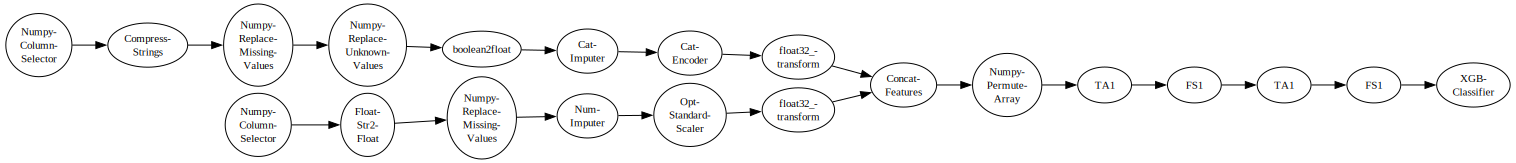

In [13]:
pipeline_name = experiment_summary.index[experiment_summary.holdout_disparate_impact.argmax()]
best_pipeline = pipeline_optimizer.get_pipeline(pipeline_name=pipeline_name)
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.


<a id="scoring"></a>
### Test pipeline model locally

#### Read the data

In [14]:
X_train, X_holdout, y_train, y_holdout = pipeline_optimizer.get_data_connections()[0].read(with_holdout_split=True)

#### Calculate metrics

For detail description of used metrics you can check the documentation:
- [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) 
- [disparate_impact](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.util.html#lale.lib.aif360.util.disparate_impact)

- [accuracy and disparate impact](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.util.html#lale.lib.aif360.util.accuracy_and_disparate_impact)

In [15]:
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact
from sklearn.metrics import accuracy_score

predicted_y = best_pipeline.predict(X_holdout.values)
disparate_impact_scorer = disparate_impact(**fairness_info)
accuracy_disparate_impact_scorer = accuracy_and_disparate_impact(**fairness_info)

print("Accuracy: {:.2f}".format(accuracy_score(y_true= y_holdout, y_pred=predicted_y)))
print("Disparate impact: {:.2f}".format(disparate_impact_scorer(best_pipeline, X_holdout, y_holdout)))
print("Accuracy and disparate impact: {:.2f}".format(accuracy_disparate_impact_scorer(best_pipeline, X_holdout, y_holdout)))

Accuracy: 0.81
Disparate impact: 1.46
Accuracy and disparate impact: 0.75


---

## Fairness insights

You can analize favorable outcome distributions using `visualize` method from `utils` module.

In [16]:
from ibm_watsonx_ai.utils.autoai.fairness import visualize

visualize(run_details, pipeline_name)

---

<a id="cleanup"></a>
## Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## Summary and next steps

 You successfully completed this notebook!
 
 As a next step you can deploy and score the model: [Sample notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/experiments/autoai/Use%20AutoAI%20and%20Lale%20to%20predict%20credit%20risk.ipynb).

 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 
 
 

## Authors
**Lukasz Cmielowski, PhD**, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

**Dorota Lączak**, software engineer in Watson Machine Learning at IBM

**Szymon Kucharczyk**, software engineer  in Watson Machine Learning at IBM

**Mateusz Szewczyk**, Software Engineer at Watson Machine Learning.

Copyright © 2021-2024 IBM. This notebook and its source code are released under the terms of the MIT License.